In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from importer_snippets import biologic_mpt_voltammetry
from LinReg import PolyReg
from scipy import interpolate
import os
plt.style.use("JGW-PPT")

# plt.rcParams["figure.figsize"] = (8,6)

In [2]:
dir_name = r"C:\Users\jgage\OneDrive - Stanford\Jaramillo Group\EC-data\Protruding-GC_JGW2-12"
technique = 'CVA'

file_list = []
data_frames = {}
for file in os.listdir(dir_name):
    if file.endswith(".mpt"):
        if technique in str(file):
            path = os.path.join(dir_name, file)
            df = biologic_mpt_voltammetry(path)
            data_frames[file] = df
            # print(str(file)[:-4] + '.csv')
            # df.to_csv(str(path)[:-4] + '.csv')
            file_list.append(file)

file_list

['1200rpm-0mm_JGW2-12-14_04_CVA_C02.mpt',
 '1200rpm-1.00mm_JGW2-12-12_04_CVA_C02.mpt',
 '1200rpm-1.00mm_JGW2-12-13_04_CVA_C02.mpt',
 '1200rpm-1.00mm_JGW2-12-15_04_CVA_C02.mpt',
 '1200rpm-1.5mm_JGW2-12-03_04_CVA_C02.mpt',
 '1200rpm-1.5mm_JGW2-12-04_04_CVA_C02.mpt',
 '1200rpm-1.5mm_JGW2-12-06_04_CVA_C02.mpt',
 '1200rpm-1.5mm_JGW2-12-07_04_CVA_C02.mpt',
 '1200rpm-1.5mm_JGW2-12-08_04_CVA_C02.mpt',
 '1200rpm-1.75mm_JGW2-12-10_04_CVA_C02.mpt',
 '1200rpm-2.25mm_JGW2-12-11_04_CVA_C02.mpt',
 '1200rpm-2mm_JGW2-12-09_04_CVA_C02.mpt']

In [3]:
series_height_names = ['1200rpm-1.5mm_JGW2-12-08_04_CVA_C02.mpt',
                       '1200rpm-1.75mm_JGW2-12-10_04_CVA_C02.mpt',
                       '1200rpm-2mm_JGW2-12-09_04_CVA_C02.mpt']

series_height = []


for i in series_height_names:
    series_height.append(data_frames[i])

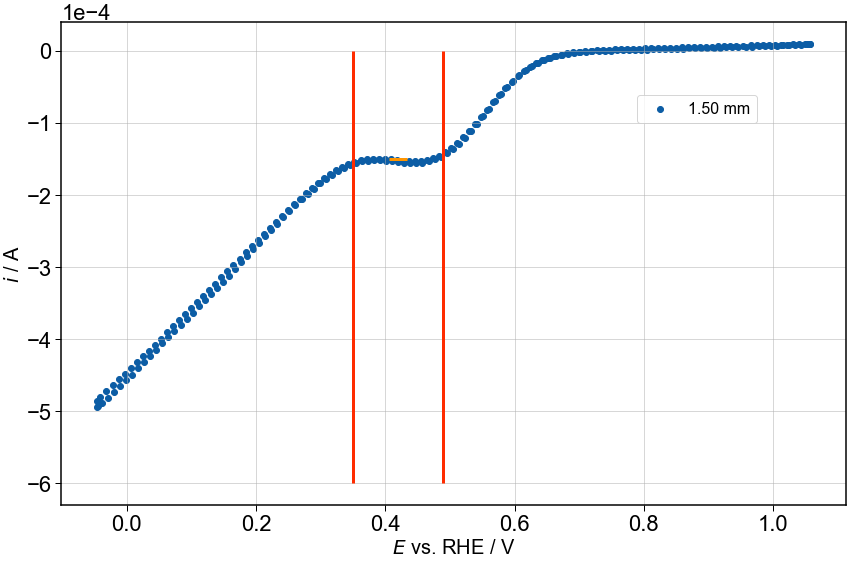

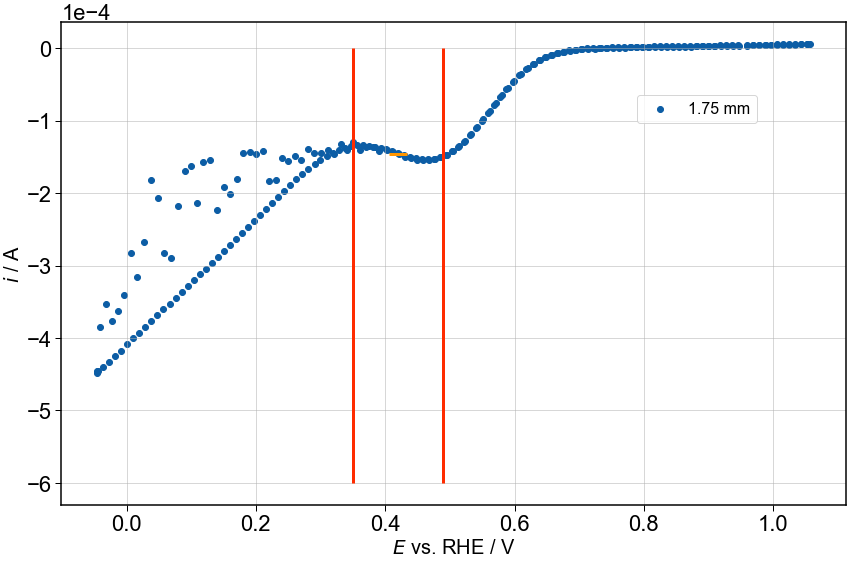

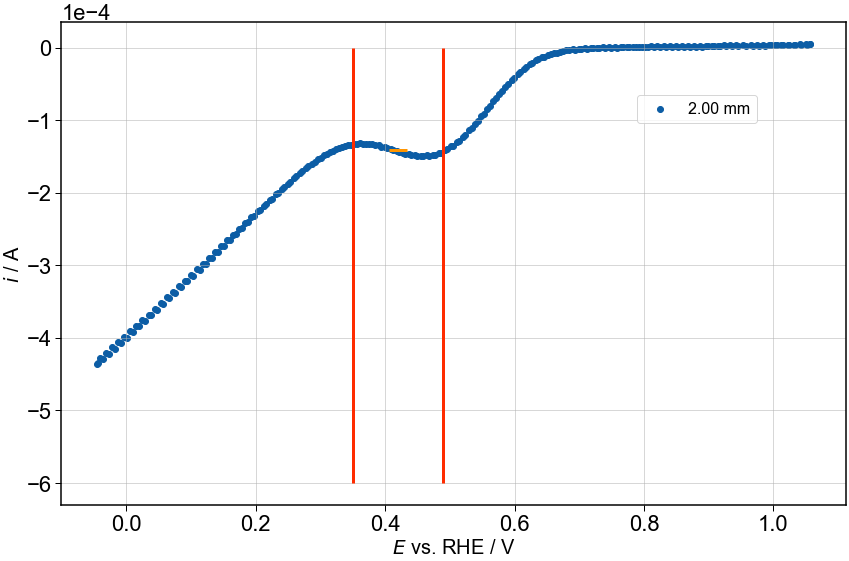

0   -0.150831
1   -0.145839
2   -0.140359
dtype: float64

In [4]:
for i in range(len(series_height)):
    # Separate forward and reverse scans
    scan_direction_bools = []
    for k in range(len(series_height[i]['Ewe/V'])):
        if k == 0:
            scan_direction_bools.append(True)
        elif series_height[i]['Ewe/V'][k - 1]  < series_height[i]['Ewe/V'][k]:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    series_height[i]['forward'] = scan_direction_bools

labels = ['1.50 mm', '1.75 mm', '2.00 mm']
selected_cycle = 2
ilc_est = []

for i in range(len(series_height)):
    fig, ax = plt.subplots()

    # Convert to RHE, current in Amps
    series_height[i]['E vs RHE'] = series_height[i]['Ewe/V'] + 0.958
    series_height[i]['<I>/A'] = series_height[i]['<I>/mA'] / 1000

    # Filter for cycle number
    x = series_height[i].loc[series_height[i]['cycle number'] == selected_cycle]['E vs RHE']
    y = series_height[i].loc[series_height[i]['cycle number'] == selected_cycle]['<I>/A']

    ax.scatter(x, y, label = labels[i], c='C00')

    # Check the middle region
    left_bound = .35
    right_bound = .49
    plt.vlines([left_bound, right_bound], -6.0e-4, 0, colors='C01')
    ilc_est.append(series_height[i].loc[series_height[i]['E vs RHE'].between(left_bound, right_bound)]['<I>/A'].mean())
    plt.scatter((left_bound+right_bound)/2, ilc_est[i], c='C03', marker='_', s=300)



    # ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.set_xlabel('$E$ vs. RHE / V')
    ax.set_ylabel('$i$ / A')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))
    fig.tight_layout()
    plt.show()

quick = pd.Series(ilc_est) * 1000
quick

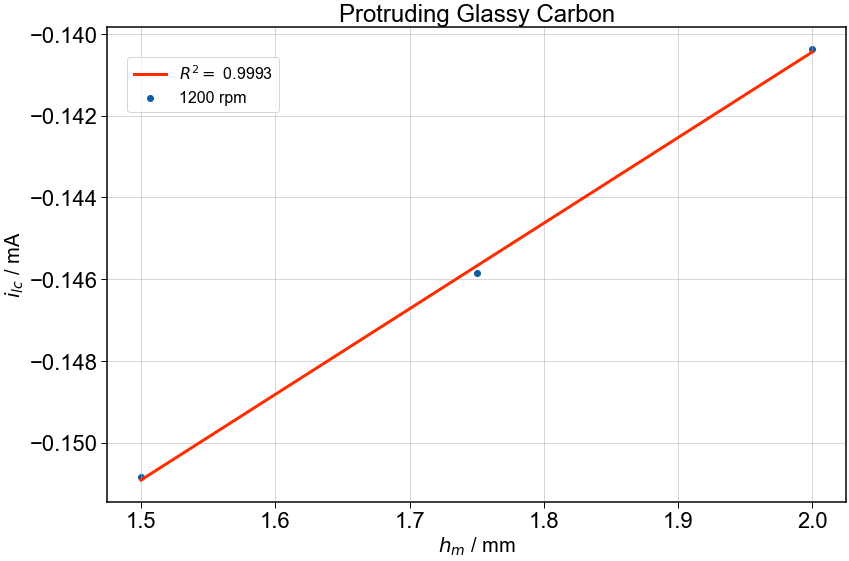

coef_deg1       2.094482e-05
std_err_deg1    5.646287e-07
coef_deg0      -1.823297e-04
std_err_deg0    9.947992e-07
r_squared       9.992738e-01
s_y             1.996264e-07
dtype: float64

In [7]:
hm = np.array([1.50, 1.75, 2.00])

x = hm
y = np.array(ilc_est)

fit = PolyReg(x, y, 1)

fig, ax = plt.subplots()

ax.scatter(x, y * 1000, label='1200 rpm') # Plot in mA, fit in A
ax.plot(x, fit.eval(x) * 1000, label='$R^2 =$ '+ '{:.4f}'.format(fit.r_squared), color='C01') # Plot in mA, fit in A
ax.set_xlabel('$h_m$ / mm')
ax.set_ylabel('$i_{lc}$ / mA')
ax.set_title('Protruding Glassy Carbon')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# fig.legend(loc=(0.75, 0.78))
fig.tight_layout()
fig.legend(loc=(0.15, 0.80))
plt.show()
fig.savefig(os.path.join(dir_name, 'ilc-hm.png'))

fit.report()